# Cats vs. Dogs using Logistic Regression
In this Jupyter Notebook, we'll implement the theory we learned in https://medium.com/@melodious/understanding-deep-neural-networks-from-first-principles-logistic-regression-bd2f01c9e263 by building a binary classifier that can predict whether an image contains a cat or a dog.

In [150]:
%matplotlib inline
# Import Packages
import os
import sys
import random
import numpy as np
from PIL import Image
from scipy import ndimage
import matplotlib as plt

## Dataset
The data is available at https://www.kaggle.com/c/dogs-vs-cats/data. Download and unzip train.zip. There are 25,000 images in the train.zip folder (12500 cat and 12500 dog images) - we'll use 80% (20k) for the training set and 20% (5k) for the test set. Move images numbered 1000 to 12499 from both dog and cat images into the ./datasets/test_cats_dogs folder. (Currently there are a few images in the folders ./datasets/train_cats_dogs and ./datasets/test_cats_dogs. Overwrite them with the dowloaded data).

### Preprocessing
Preprocessing data in order to feed it into the model is often times the most time-consuming part of the machine learning process. In batch_processing() we resize the images to have a consistent width and height of 500 pixels. We then define a method load_data() to convert the images to a numpy array of size (width) x (height) x (# of channels). Since the files are named with either 'Cat' or 'Dog' in the filename, we check for the string and set the label y = 0 for a cat and y = 1 for a dog. We then randomize the files in the directory so that all the cats and dogs aren't lumped together.

In [178]:
def batch_preprocessing():
    width = 500
    height = 500
    train_dir = 'datasets/train_cats_dogs/'
    test_dir = 'datasets/test_cats_dogs/'

    # Pre-process training set
    for image in os.listdir(train_dir):
        if image.endswith('.DS_Store'):
            continue
        print('Resizing image ' + image)
        img = Image.open(os.path.join(train_dir,image))
        img = img.resize((width,height), Image.BILINEAR)
        img.save(os.path.join(train_dir,image))
        
    print('Batch pre-processing on {} files in training set complete'.format(len(os.listdir(train_dir))))
    print('///////////////')
    # Pre-process test set
    for image in os.listdir(test_dir):
        if image.endswith('.DS_Store'):
            continue
        print('Resizing image ' + image)
        img = Image.open(os.path.join(test_dir,image))
        img = img.resize((width,height), Image.BILINEAR)
        img.save(os.path.join(test_dir,image))
    print('Batch pre-processing on {} files in test set complete'.format(len(os.listdir(test_dir))))

In [196]:
def load_data():
    
    train_dir = 'datasets/train_cats_dogs'
    test_dir = 'datasets/test_cats_dogs'
    
    # initialize arrays
    files_train = len(os.listdir(train_dir))
    files_test = len(os.listdir(test_dir))
    train_set_x = np.random.randint(0,255,size=(files_train,500,500,3),dtype='uint8')
    train_set_y = np.zeros((1,files_train))
    test_set_x = np.random.randint(0,255,size=(files_test,500,500,3),dtype='uint8')
    test_set_y = np.zeros((1,files_test))

    # load training files
    for i,image in zip(range(files_train),os.listdir(train_dir)):   
        if image.endswith('.DS_Store'):
            continue
        train_set_x[i] = np.array(Image.open(os.path.join(train_dir,image)))
        # create training set labels (0: cat, 1: dog)
        if 'dog' in str(image):
            train_set_y[0,i] = 1
            
    # load test files 
    for i,image in zip(range(files_test),os.listdir(test_dir)):   
        if image.endswith('.DS_Store'):
            continue
        test_set_x[i] = np.array(Image.open(os.path.join(test_dir,image)))
        # create test set labels (0: cat, 1: dog)
        if 'dog' in str(image):
            test_set_y[0,i] = 1

    # randomize files 
    idx_train = np.random.permutation(files_train)
    idx_test = np.random.permutation(files_test)
    train_set_x, train_set_y = train_set_x[idx_train,:], train_set_y[:,idx_train]
    test_set_x, test_set_y = test_set_x[idx_test,:], test_set_y[:,idx_test]

    # make sure arrays are correctly shaped
    assert(train_set_x.shape == (files_train,500,500,3))
    assert(train_set_y.shape == (1,files_train))
    assert(test_set_x.shape == (files_test,500,500,3))
    assert(test_set_y.shape == (1,files_test))
    
    return train_set_x,train_set_y,test_set_x,test_set_y

### Visualize and split data
After loading the data, it's helpful to visualize it.
We also split the training data and keep 80% as the training set and 20% as the validation set. This way, we can train and check our results without contaminating and overfitting to our test set.

In [180]:
batch_preprocessing()
train_set_x,train_set_y,test_set_x,test_set_y = load_data()

Resizing image cat.0.jpg
Resizing image cat.1.jpg
Resizing image cat.10.jpg
Resizing image cat.10006.jpg
Resizing image cat.10007.jpg
Resizing image cat.10008.jpg
Resizing image cat.10009.jpg
Resizing image cat.10010.jpg
Resizing image cat.11.jpg
Resizing image cat.12.jpg
Resizing image cat.13.jpg
Resizing image cat.14.jpg
Resizing image cat.15.jpg
Resizing image cat.16.jpg
Resizing image cat.17.jpg
Resizing image cat.18.jpg
Resizing image cat.19.jpg
Resizing image cat.2.jpg
Resizing image cat.20.jpg
Resizing image cat.3.jpg
Resizing image cat.4.jpg
Resizing image cat.5.jpg
Resizing image cat.6.jpg
Resizing image cat.7.jpg
Resizing image cat.8.jpg
Resizing image cat.9.jpg
Resizing image dog.0.jpg
Resizing image dog.1.jpg
Resizing image dog.10.jpg
Resizing image dog.10006.jpg
Resizing image dog.10007.jpg
Resizing image dog.10008.jpg
Resizing image dog.10009.jpg
Resizing image dog.10010.jpg
Resizing image dog.11.jpg
Resizing image dog.12.jpg
Resizing image dog.13.jpg
Resizing image dog.1

1.0


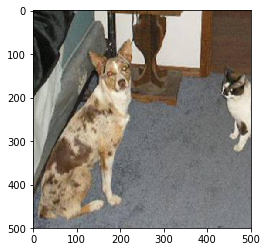

In [181]:
# Visualize an example
plt.pyplot.imshow(train_set_x[19])
print(train_set_y[0,19])

# Split 80% of training set data, use other 20% as validation set
cut_off = int(train_set_x.shape[0]*0.8)
val = train_set_x.shape[0]-cut_off
#print(cut_off)
train_set_x_split = train_set_x[0:cut_off]
train_set_y_split = train_set_y[0,0:cut_off].reshape(1,cut_off)
validation_set_x = train_set_x[cut_off:]
validation_set_y = train_set_y[0,cut_off:].reshape(1,val)


### Flatten images
An image is of shape 500 x 500 x 3 (height x width x number of channels). We'll flatten the matrix to be a vector of shape 500x500x3 = 750000 and standardize the image by dividing by 255 (the maximum value of a color pixel)

In [182]:
# Define number of training, validation, and test examples and image dimensions  
m_train = train_set_x.shape[0]
m_val = validation_set_x.shape[0]
m_test = test_set_x.shape[0]
num_px = train_set_x.shape[1]

# Flatten images into vectors
train_set_x_flatten = train_set_x_split.reshape(train_set_x_split.shape[0],-1).T
validation_set_x_flatten = np.reshape(validation_set_x,(num_px*num_px*3,m_val))
test_set_x_flatten = np.reshape(test_set_x,(num_px*num_px*3,m_test))
#print(train_set_x_flatten.shape,validation_set_x_flatten.shape, test_set_x_flatten.shape)

# Standardize images by dividing by max value of a pixel channel (255)
train_set_x_standardized = train_set_x_flatten/255.
validation_set_x_standardized = validation_set_x_flatten/255.
test_set_x_standardized = test_set_x_flatten/255.

In [183]:
# Print out all the shapes
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of validation examples: m_val = " + str(m_val))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("\\\\\\\\\\\\\\\\")
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_x_split shape: " + str(train_set_x_split.shape))
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_x_standardized shape: " + str(train_set_x_standardized.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("train_set_y_split shape: " + str(train_set_y_split.shape))
print("\\\\\\\\\\\\\\\\")
print ("validation_set_x shape: " + str(validation_set_x.shape))
print ("validation_set_x_flatten shape: " + str(validation_set_x_flatten.shape))
print ("validation_set_x_standardized shape: " + str(validation_set_x_standardized.shape))
print ("validation_set_y shape: " + str(validation_set_y.shape))
print("\\\\\\\\\\\\\\\\")
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_x_standardized shape: " + str(test_set_x_standardized.shape))
print ("test_set_y shape: " + str(test_set_y.shape))


Number of training examples: m_train = 52
Number of validation examples: m_val = 11
Number of testing examples: m_test = 21
Height/Width of each image: num_px = 500
Each image is of size: (500, 500, 3)
\\\\\\\\
train_set_x shape: (52, 500, 500, 3)
train_set_x_split shape: (41, 500, 500, 3)
train_set_x_flatten shape: (750000, 41)
train_set_x_standardized shape: (750000, 41)
train_set_y shape: (1, 52)
train_set_y_split shape: (1, 41)
\\\\\\\\
validation_set_x shape: (11, 500, 500, 3)
validation_set_x_flatten shape: (750000, 11)
validation_set_x_standardized shape: (750000, 11)
validation_set_y shape: (1, 11)
\\\\\\\\
test_set_x shape: (21, 500, 500, 3)
test_set_x_flatten shape: (750000, 21)
test_set_x_standardized shape: (750000, 21)
test_set_y shape: (1, 21)


## Logistic Regression Model

We are finally ready to implement the model - we'll do so in steps. 

### Step-by-step
First we define the sigmoid function. Then we implement forward and backward propagation. Note that we compute and store the gradients dw and db during backprop. We then use them to update w and b for each iteration during our optimization phase. Finally, we use the learned parameters to predict the value of the output, using 0.5 as a threshold value to determine whether y=0 or y=1.

In [184]:
def sigmoid(z, deriv = False):
    s = 1/(1+np.exp(-z))
    if deriv:
        ds = s*(1-s)
        return s, ds
    return s

In [185]:
def propagate(w,b,X,Y):
    m = X.shape[1]
    # forward prop
    A = sigmoid(np.dot(np.transpose(w),X)+b)
    cost = (-1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    # backprop
    dw = (1/m)*np.dot(X,np.transpose(A-Y))
    db = (1/m)*np.sum(A-Y)

    # Ensuring cost is a scalar by removing any dimensions of length 1
    cost = np.squeeze(cost)

    # Gradients are stored in a dictionary for use during optimization phase
    grads = {"dw": dw,
            "db": db}
    
    return grads,cost

In [186]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        #Record and print costs every 100 training examples
        if i % 10 == 0:
            costs.append(cost)    
        if print_cost and i % 10 == 0:
            print("Cost after iteration i: {}".format(i,cost))
    
    # Params and grads are stored in a dictionary for use during each iteration
    params = {"w": w,
              "b": b}
        
    grads = {"dw": dw,
             "db": db}
        
    return params, grads, costs

In [187]:
def predict(w,b,X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        Y_prediction[np.where(A>0.5)] = 1
    
    return Y_prediction

### Defining the model
We combine the helper functions defined above into a model. Note the values for the # of iterations and learning rate. Play around with those values to see how they affect the prediction accuracy.

In [188]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.6, print_cost=False):
    
    # Intialize w and b
    w = np.zeros((X_train.shape[0],1))
    b = np.zeros(1)
    
    # Learning the values of w and b 
    parameters, grads, costs = optimize(w,b,X_train,Y_train, num_iterations, learning_rate)
    w = parameters["w"]
    b = parameters["b"]
    
    # Predicting the accuracy of the trained model on our test set 
    # We also predict how well the model does on the training set
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    
    # Calculating the accuracy of the model
    print("Training set accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_train-Y_train) * 100)))
    print("Test set accuracy: {}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    model_out = {"costs": costs,
                     "Y_prediction_test": Y_prediction_test,
                     "Y_prediction_train": Y_prediction_train,
                     "w": w,
                     "b": b,
                     "learning_rate": learning_rate,
                     "num_iterations": num_iterations}
    return model_out

### Running the model on our dataset
We've finally arrived at the moment of truth! How well does logistic regression do on the cats vs. dogs dataset?
First we'll check train our model on the training set and check the accuracy on the validation set. See what learning rate and iterations give you the best accuracy value.

In [ ]:
learning_rates = [0.1, 0.01, 0.005]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x_standardized, train_set_y_split, validation_set_x_standardized, validation_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.pyplot.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.pyplot.ylabel('cost')
plt.pyplot.xlabel('iterations')

legend = plt.pyplot.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.pyplot.show()

In [ ]:
model_out = model(train_set_x_standardized, train_set_y_split, validation_set_x_standardized, validation_set_y, num_iterations = 2000, learning_rate = 0.1, print_cost = True)





We'll finally see how the model does on our test test. 

In [189]:
model_out = model(train_set_x_standardized, train_set_y_split, test_set_x_standardized, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)





Training set accuracy: 56.0975609756%
Test set accuracy: 28.5714285714%


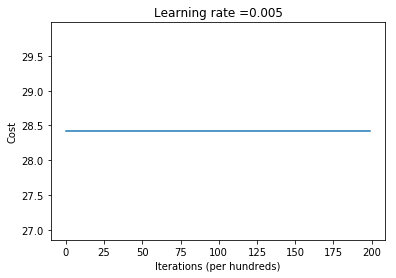

In [195]:
# Plot learning curve (with costs)
costs = np.squeeze(model_out['costs'])
plt.pyplot.plot(costs)
plt.pyplot.ylabel('Cost')
plt.pyplot.xlabel('Iterations (per hundreds)')
plt.pyplot.title("Learning rate =" + str(model_out["learning_rate"]))
plt.pyplot.show()
